# TP4 DEEP LEARNING
Realised by : 
- Noureddine Ben Nejma
- Mehdi Cherif
- Med Ali Selmi
- Walid Sboui

In [2]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
from tensorflow.keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import Conv1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import LSTM
from keras.layers import Embedding
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
import seaborn as sns
from numpy import array
from numpy import asarray
from numpy import zeros
from matplotlib import pyplot as plt
from keras.layers import GRU
from gensim.models import Word2Vec
from gensim.models import FastText
from sklearn.feature_extraction.text import TfidfVectorizer


### Load data : 

Shape of the data:  (50000, 2)
Columns present in the data:  Index(['review', 'sentiment'], dtype='object')
Data type of each column: 
 review       object
sentiment    object
dtype: object
First 5 rows of the data:                                                review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
4éme review :  Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable.

<Axes: xlabel='sentiment', ylabel='count'>

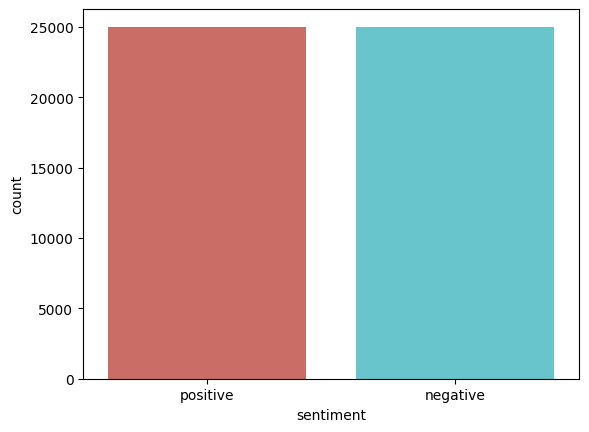

In [5]:
data = pd.read_csv('IMDB Dataset.csv')
print("Shape of the data: ", data.shape)
print("Columns present in the data: ", data.columns)
print("Data type of each column: \n", data.dtypes)
print("First 5 rows of the data: ", data.head())
print("4éme review : ", data['review'][3])
sns.countplot(x='sentiment', data=data, palette='hls', hue='sentiment', dodge=False)


### Preprocess DATA

In [6]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

def preprocess_text(sen):
    sentence = remove_tags(sen)
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    sentence = re.sub(r'\s+', ' ', sentence)
    return sentence

X = []
sentences = list(data['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

print("4éme review: ", X[3])

y = data['sentiment']
y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

4éme review:  Basically there a family where little boy Jake thinks there a zombie in his closet his parents are fighting all the time This movie is slower than soap opera and suddenly Jake decides to become Rambo and kill the zombie OK first of all when you re going to make film you must Decide if its thriller or drama As drama the movie is watchable Parents are divorcing arguing like in real life And then we have Jake with his closet which totally ruins all the film expected to see BOOGEYMAN similar movie and instead watched drama with some meaningless thriller spots out of just for the well playing parents descent dialogs As for the shots with Jake just ignore them 


### Embedding layer : 

In [4]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [7]:
embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [8]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [9]:
embedding_matrix.shape

(92547, 100)

### Classification model : 

In [25]:
def first_model():
    model = Sequential()
    embedding_layer = Embedding(vocab_size, 100, input_shape=(maxlen,) , trainable=False)
    model.add(embedding_layer)
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    embedding_layer.set_weights([embedding_matrix])
    return model

def second_model():
    model = Sequential()
    embedding_layer = Embedding(vocab_size, 100, input_shape=(maxlen,) , trainable=False)
    model.add(embedding_layer)
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    embedding_layer.set_weights([embedding_matrix])
    return model

def third_model():
    model = Sequential()
    embedding_layer = Embedding(vocab_size, 100, input_shape=(maxlen,) , trainable=False)
    model.add(embedding_layer)
    model.add(LSTM(128))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    embedding_layer.set_weights([embedding_matrix])    
    return model

def fit_and_evaluate(model, X_train, y_train, X_test, y_test, epochs=6, batch_size=128, verbose=1, validation_split=0.2):
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_split=validation_split)
    score = model.evaluate(X_test, y_test, verbose=1)
    print("Test Score:", score[0])
    print("Test Accuracy:", score[1])
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()

#### First model : 

Epoch 1/6


c:\Users\user\.pyenv\pyenv-win\versions\3.12.1\Lib\site-packages\keras\src\layers\core\embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


250/250 ━━━━━━━━━━━━━━━━━━━━ 29s 113ms/step - acc: 0.6297 - loss: 0.6484 - val_acc: 0.8011 - val_loss: 0.4351
Epoch 2/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 27s 107ms/step - acc: 0.8486 - loss: 0.3600 - val_acc: 0.8339 - val_loss: 0.3756
Epoch 3/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 27s 110ms/step - acc: 0.8913 - loss: 0.2723 - val_acc: 0.8430 - val_loss: 0.3635
Epoch 4/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 28s 111ms/step - acc: 0.9239 - loss: 0.2133 - val_acc: 0.8421 - val_loss: 0.3681
Epoch 5/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 29s 116ms/step - acc: 0.9515 - loss: 0.1622 - val_acc: 0.8409 - val_loss: 0.3816
Epoch 6/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - acc: 0.9713 - loss: 0.1206 - val_acc: 0.8378 - val_loss: 0.3998
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.8378 - loss: 0.3919
Test Score: 0.38515833020210266
Test Accuracy: 0.8406000137329102


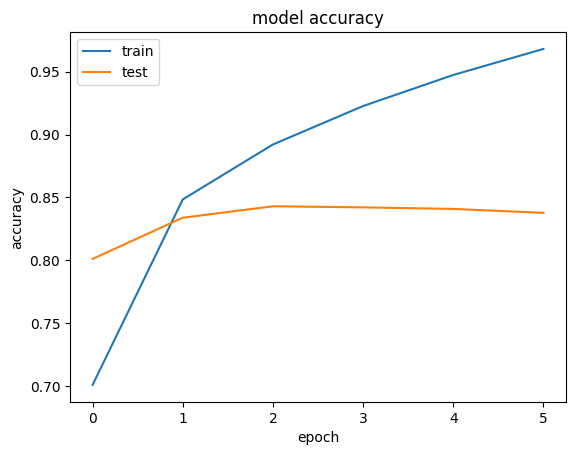

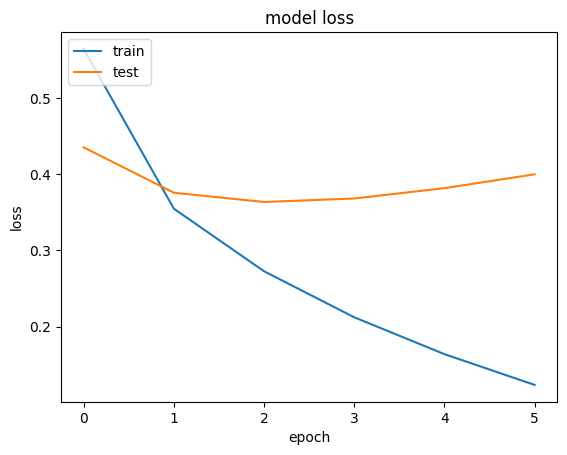

In [23]:
model1 = first_model()
fit_and_evaluate(model1, X_train, y_train, X_test, y_test)

#### Second model : 

c:\Users\user\.pyenv\pyenv-win\versions\3.12.1\Lib\site-packages\keras\src\layers\core\embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 36s 140ms/step - acc: 0.7050 - loss: 0.5495 - val_acc: 0.8425 - val_loss: 0.3509
Epoch 2/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - acc: 0.8704 - loss: 0.3088 - val_acc: 0.8555 - val_loss: 0.3277
Epoch 3/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 35s 140ms/step - acc: 0.9099 - loss: 0.2358 - val_acc: 0.8679 - val_loss: 0.3104
Epoch 4/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 37s 147ms/step - acc: 0.9369 - loss: 0.1845 - val_acc: 0.8662 - val_loss: 0.3166
Epoch 5/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 37s 146ms/step - acc: 0.9574 - loss: 0.1401 - val_acc: 0.8660 - val_loss: 0.3300
Epoch 6/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 34s 138ms/step - acc: 0.9782 - loss: 0.0956 - val_acc: 0.8658 - val_loss: 0.3394
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.8684 - loss: 0.3192
Test Score: 0.31974929571151733
Test Accuracy: 0.8708999752998352


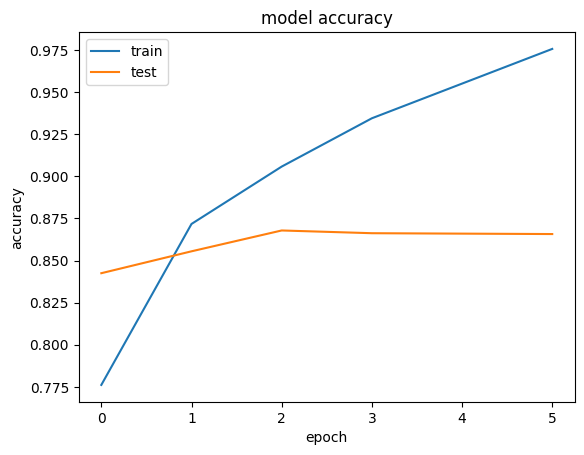

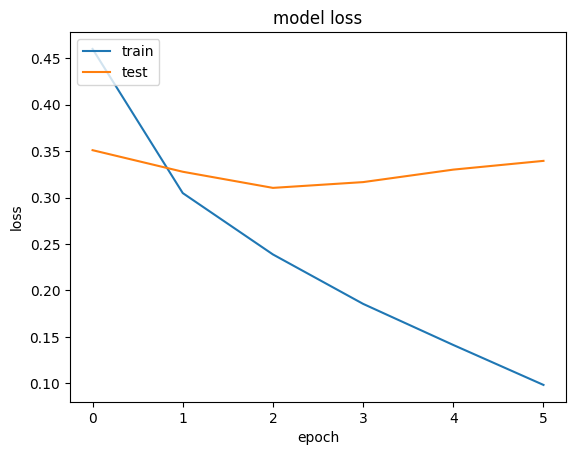

In [26]:
model2 = second_model()
fit_and_evaluate(model2, X_train, y_train, X_test, y_test)

#### Third model : 

Epoch 1/6


c:\Users\user\.pyenv\pyenv-win\versions\3.12.1\Lib\site-packages\keras\src\layers\core\embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


250/250 ━━━━━━━━━━━━━━━━━━━━ 64s 248ms/step - acc: 0.6495 - loss: 0.6000 - val_acc: 0.8099 - val_loss: 0.4394
Epoch 2/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 64s 254ms/step - acc: 0.8574 - loss: 0.3358 - val_acc: 0.8342 - val_loss: 0.3652
Epoch 3/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 72s 290ms/step - acc: 0.8820 - loss: 0.2913 - val_acc: 0.8589 - val_loss: 0.3447
Epoch 4/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 66s 263ms/step - acc: 0.8926 - loss: 0.2728 - val_acc: 0.8476 - val_loss: 0.3360
Epoch 5/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 63s 251ms/step - acc: 0.8969 - loss: 0.2578 - val_acc: 0.8611 - val_loss: 0.3372
Epoch 6/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 63s 252ms/step - acc: 0.9198 - loss: 0.2132 - val_acc: 0.8599 - val_loss: 0.3391
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - acc: 0.8597 - loss: 0.3350
Test Score: 0.323501855134964
Test Accuracy: 0.8661999702453613


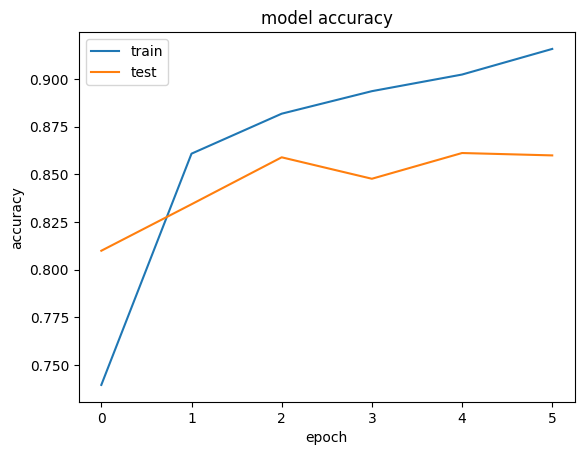

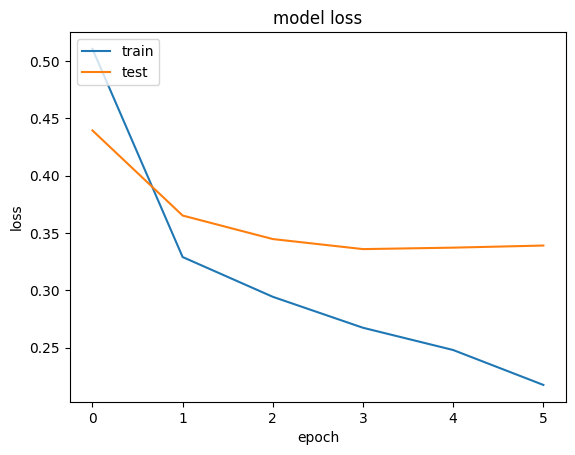

In [27]:
third_model = third_model()
fit_and_evaluate(third_model, X_train, y_train, X_test, y_test)

## Compte Rendu

In [7]:
def LSTM_Classifier(embedding_matrix):
    model = Sequential()
    embedding_layer = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], input_shape=(maxlen,), trainable=False)
    model.add(embedding_layer)
    model.add(LSTM(128))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    embedding_layer.set_weights([embedding_matrix])
    return model


def GRU_Classifier(embedding_matrix):
    model = Sequential()
    embedding_layer = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], input_shape=(maxlen,), trainable=False)
    model.add(embedding_layer)
    model.add(GRU(128))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    embedding_layer.set_weights([embedding_matrix])
    return model

def RNN_plus_CNN_Classifier(embedding_matrix):
    model = Sequential()
    embedding_layer = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], input_shape=(maxlen,), trainable=False)
    model.add(embedding_layer)
    model.add(LSTM(128, return_sequences=True))
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    embedding_layer.set_weights([embedding_matrix])
    return model

In [8]:
def embed_using_glove(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
    tokenizer = Tokenizer(num_words=5000)
    tokenizer.fit_on_texts(X_train)
    X_train = tokenizer.texts_to_sequences(X_train)
    X_test = tokenizer.texts_to_sequences(X_test)
    vocab_size = len(tokenizer.word_index) + 1
    maxlen = 100
    X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
    X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
    embeddings_dictionary = dict()
    glove_file = open('glove.6B.100d.txt', encoding="utf8")
    for line in glove_file:
        records = line.split()
        word = records[0]
        vector_dimensions = asarray(records[1:], dtype='float32')
        embeddings_dictionary [word] = vector_dimensions
    glove_file.close()
    embedding_matrix = zeros((vocab_size, 100))
    for word, index in tokenizer.word_index.items():
        embedding_vector = embeddings_dictionary.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector
    return X_train, X_test, y_train, y_test, embedding_matrix


def embed_using_Word2vec(X,y):
    model = Word2Vec(sentences=X, vector_size=100, window=5, workers=4, min_count=1)
    embedding_matrix = []
    words = list(model.wv.key_to_index)
    for word in words:
        embedding_matrix.append(model.wv[word])
    embedding_matrix = asarray(embedding_matrix)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
    tokenizer = Tokenizer(num_words=5000)
    tokenizer.fit_on_texts(X_train)
    X_train = tokenizer.texts_to_sequences(X_train)
    X_test = tokenizer.texts_to_sequences(X_test)
    vocab_size = len(tokenizer.word_index) + 1
    maxlen = 100
    X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
    X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
    return X_train, X_test, y_train, y_test, embedding_matrix


def embed_using_fasttext(X,y):
    model = FastText(sentences=X, vector_size=100, window=5, workers=4, min_count=1)
    embedding_matrix = []
    words = list(model.wv.key_to_index)
    for word in words:
        embedding_matrix.append(model.wv[word])
    embedding_matrix = asarray(embedding_matrix)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
    tokenizer = Tokenizer(num_words=5000)
    tokenizer.fit_on_texts(X_train)
    X_train = tokenizer.texts_to_sequences(X_train)
    X_test = tokenizer.texts_to_sequences(X_test)
    vocab_size = len(tokenizer.word_index) + 1
    maxlen = 100
    X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
    X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
    return X_train, X_test, y_train, y_test, embedding_matrix

def embed_using_tfidf(X,y):
    vectorizer = TfidfVectorizer(max_features=100) 
    tfidf_matrix = vectorizer.fit_transform(X)
    model = Word2Vec(sentences=tfidf_matrix.toarray(), vector_size=100, window=5, workers=4, min_count=1)
    words = list(model.wv.key_to_index)
    embedding_matrix = []
    for word in words:
        embedding_matrix.append(model.wv[word])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
    return X_train, X_test, y_train, y_test, embedding_matrix


In [1]:
results = np.zeros((3,4))
def test_models(X,y):
    X_train, X_test, y_train, y_test, embedding_matrix = embed_using_glove(X,y)
    model1 = LSTM_Classifier(embedding_matrix)
    model2 = GRU_Classifier(embedding_matrix)
    model3 = RNN_plus_CNN_Classifier(embedding_matrix)
    print("IN 0,0")
    model1.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)
    results[0,0] = model1.evaluate(X_test, y_test, verbose=1)[1]
    print("IN 1,0")
    model2.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)
    results[1,0] = model2.evaluate(X_test, y_test, verbose=1)[1]
    print("IN 2,0")
    model3.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)
    results[2,0] = model3.evaluate(X_test, y_test, verbose=1)[1]
    X_train, X_test, y_train, y_test, embedding_matrix = embed_using_Word2vec(X,y)
    model1 = LSTM_Classifier(embedding_matrix)
    model2 = GRU_Classifier(embedding_matrix)
    model3 = RNN_plus_CNN_Classifier(embedding_matrix)
    print("IN 0,1")
    model1.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)
    results[0,1] = model1.evaluate(X_test, y_test, verbose=1)[1]
    print("IN 1,1")
    model2.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)
    results[1,1] = model2.evaluate(X_test, y_test, verbose=1)[1]
    print("IN 2,1")
    model3.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)
    results[2,1] = model3.evaluate(X_test, y_test, verbose=1)[1]
    X_train, X_test, y_train, y_test, embedding_matrix = embed_using_fasttext(X,y)
    model1 = LSTM_Classifier(embedding_matrix)
    model2 = GRU_Classifier(embedding_matrix)
    model3 = RNN_plus_CNN_Classifier(embedding_matrix)
    model1.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)
    print("IN 0,2")
    results[0,2] = model1.evaluate(X_test, y_test, verbose=1)[1]
    model2.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)
    print("IN 1,2")
    results[1,2] = model2.evaluate(X_test, y_test, verbose=1)[1]
    model3.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)
    print("IN 2,2")
    results[2,2] = model3.evaluate(X_test, y_test, verbose=1)[1]
    # X_train, X_test, y_train, y_test, embedding_matrix = embed_using_tfidf(X,y)
    # model1 = LSTM_Classifier(embedding_matrix)
    # model2 = GRU_Classifier(embedding_matrix)
    # model3 = RNN_plus_CNN_Classifier(embedding_matrix)
    # model1.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)
    # print("IN 0,3")
    # results[0,3] = model1.evaluate(X_test, y_test, verbose=1)[1]
    # model2.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)
    # print("IN 1,3")
    # results[1,3] = model2.evaluate(X_test, y_test, verbose=1)[1]
    # model3.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)
    # print("IN 2,3")
    # results[2,3] = model3.evaluate(X_test, y_test, verbose=1)[1]

def convert_to_dataframe(results):
    df = pd.DataFrame(results, columns=['Glove', 'Word2Vec', 'FastText', 'TF-IDF'], index=['LSTM', 'GRU', 'RNN+CNN'])
    return df

test_models(X,y)
df = convert_to_dataframe(results)
print(df)

NameError: name 'np' is not defined